In [1]:
import pandas as pd
from fastai import *
from fastai.text import * 

In [2]:
DATA_PATH = './data'

# DATA PREPARATION

In [3]:
def prepare_csv(source, target):
    df = pd.read_csv(source, sep= '%%%%', header=None)
    df[['label', 'question']] = df.iloc[:,0].str.split(":", n = 1, expand = True) 
    df[['label_detail', 'question']] = df.question.str.split(" ", n = 1, expand = True) 
    df = df.drop(df.columns[0], axis=1)
    df.to_csv(target, index=False)

In [4]:
prepare_csv(DATA_PATH  + '/TREC_10.label', DATA_PATH  + '/TREC_10.csv')
prepare_csv(DATA_PATH  + '/train_5500.label', DATA_PATH  + '/train_5500.csv' )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [5]:
df_valid = pd.read_csv(DATA_PATH  + '/TREC_10.csv')
df_train = pd.read_csv(DATA_PATH  + '/train_5500.csv')
df_valid['is_valid'] = 1
df_train['is_valid'] = 0
df_all = pd.concat([df_valid, df_train], ignore_index=True)

# LANGUAGE MODEL

In [6]:
# Creating databunch with all data for language model
databunch_lm = (
        TextList.from_df(df=df_all, path=DATA_PATH, cols=['question'])
            .split_by_rand_pct()
            .label_for_lm()
            .databunch())

databunch_lm.save('databunch_lm.pkl')
databunch_lm = load_data(DATA_PATH, fname='databunch_lm.pkl')

In [7]:
# Creating learner with pretrained model
language_model_learner = language_model_learner(databunch_lm, Transformer, drop_mult=0.05)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02


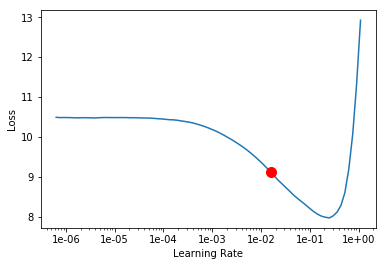

In [8]:
# Finding the best learning rate 

# language_model_learner.lr_find()
# language_model_learner.recorder.plot(suggestion=True)

In [9]:
language_model_learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [70, 768]            1,486,080  True      
______________________________________________________________________
Embedding            [768]                393,216    True      
______________________________________________________________________
Dropout              [70, 768]            0          False     
______________________________________________________________________
Linear               [70, 2304]           1,771,776  False     
______________________________________________________________________
Linear               [70, 768]            590,592    False     
______________________________________________________________________
Dropout              [12, 70, 70]         0          False     
______________________________________________________________________
Dropout              [70, 768]            0          False     
______________________________________________________________

In [10]:
# Training only last layer
language_model_learner.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.291127,4.527550,0.232143,09:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04


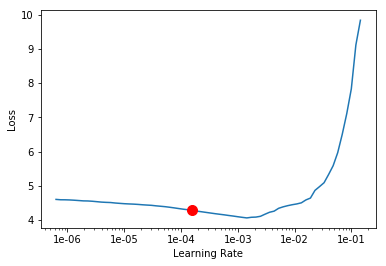

In [12]:
# Finding the best learning rate when unfreezed

# language_model_learner.unfreeze()
# language_model_learner.lr_find()
# language_model_learner.recorder.plot(suggestion=True)

In [14]:
# Unfreezing and training all layers
language_model_learner.unfreeze()
language_model_learner.fit_one_cycle(5, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,4.007821,3.470712,0.391183,11:09
1,3.732893,3.201761,0.427902,10:45
2,3.491808,2.955190,0.467690,10:46
3,3.307531,2.877581,0.477344,10:43
4,3.169737,2.857398,0.478739,10:43


In [15]:
language_model_learner.fit_one_cycle(5, 5e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.880779,2.849455,0.480525,10:41
1,2.864721,2.830786,0.483482,10:42
2,2.841345,2.810249,0.485826,10:43
3,2.814003,2.797354,0.487500,10:49
4,2.791276,2.797007,0.487946,10:43


In [16]:
# Saving encoder
language_model_learner.save_encoder('encoder_transformer')

# CLASSIFIER

In [17]:
# Creating databunch with all data for classifier using previous vocab
databunch_classifier = (
        TextList.from_df(df=df_all, path=DATA_PATH, cols=['question'], vocab=databunch_lm.train_ds.vocab)
            .split_from_df(col='is_valid')
            .label_from_df(cols='label')
            .databunch())

databunch_classifier.save('databunch_classifier.pkl')
databunch_classifier = load_data(DATA_PATH, fname='databunch_classifier.pkl', bs=16)

In [18]:
# Creating text classifier learner
classifier_learner = text_classifier_learner(databunch_classifier, Transformer, drop_mult=0.05)
classifier_learner.load_encoder('encoder_transformer')

In [19]:
# Example of a batch
databunch_classifier.show_batch()

text,target
"xxbos xxmaj who was named xxmaj xxunk of the xxmaj ocean xxmaj seas and xxmaj xxunk and xxmaj governor xxmaj general of all the islands he xxunk discover , and also xxunk xxunk ? ? of all xxunk of his xxunk",HUM
xxbos xxmaj what year is xxunk on the xxmaj gold xxmaj xxunk of xxmaj xxunk from the xxmaj xxunk xxmaj xxunk xxunk on a can of xxmaj xxunk 's xxunk soup,NUM
"xxbos xxmaj why was xxmaj henry xxmaj ford 's first automobile xxunk xxmaj model t & his second type of automobile , introduced in xxunk , called a xxmaj model a",DESC
"xxbos xxmaj in what sport are these following numbers xxunk : xxunk , xxunk , xxunk , xxunk , 15 , xxunk , xxunk , xxunk , and 19",ENTY
xxbos xxmaj who sang the song ` ` xxmaj xxunk on a xxmaj xxunk '' in the xxunk baby xxunk of ` ` xxmaj xxunk xxmaj xxunk '',HUM


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01


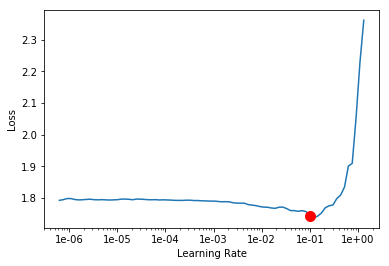

In [20]:
# Finding learning rate

classifier_learner.lr_find()
classifier_learner.recorder.plot(suggestion=True)

In [21]:
# Training only last layer
classifier_learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.341172,1.611559,0.360000,11:53


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


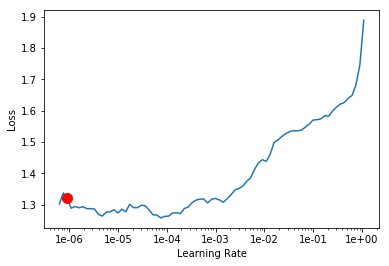

In [22]:
# Finding the best learning rate when unfreezed

classifier_learner.unfreeze()
classifier_learner.lr_find()
classifier_learner.recorder.plot(suggestion=True)

In [23]:
classifier_learner.unfreeze()
classifier_learner.fit_one_cycle(5, slice(1e-7, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,1.277769,1.476677,0.408000,19:24
1,1.211278,1.306957,0.448000,22:08
2,1.106010,1.271583,0.468000,26:02
3,1.098465,1.234933,0.488000,24:32
4,1.027760,1.233011,0.470000,25:57


In [24]:
classifier_learner.export('classifier_transformer')

In [25]:
classifier_learner = load_learner(DATA_PATH/'clasifier_transformer')

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
classifier_learner.predict("How many players are in a football field?")
